In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import datetime

from os.path                                 import dirname
from tensorflow.keras.applications.resnet50  import ResNet50
from tensorflow.keras.applications.densenet  import DenseNet121
from tensorflow.keras                        import Sequential, layers, Model
from tensorflow.keras.callbacks              import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from sklearn.metrics                         import classification_report, accuracy_score

from dataload                                import *
from util                                    import *

In [2]:
path = "/Users/chintu/Documents/DS/Emergency Vehicles Detection/data/"

In [3]:
loader = DataLoader(path+"train/images/", path)

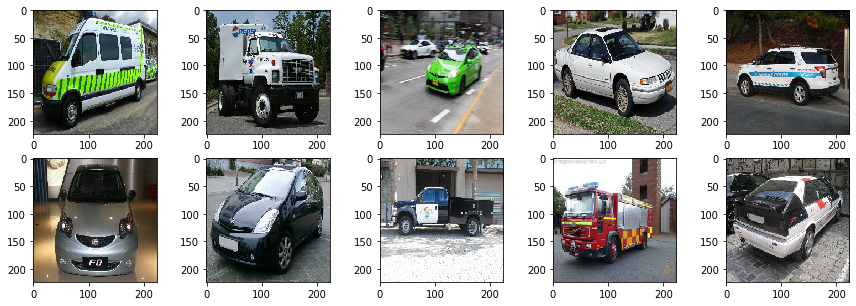

In [4]:
loader.display_samples(grid=(2, 5), figsize=(15, 5))

In [5]:
train_dataset, val_dataset, test_dataset = loader.train_test_split(train_split=0.75, batch_size=64)

In [6]:
data_aug = Sequential([
    layers.experimental.preprocessing.RandomFlip(),
    layers.experimental.preprocessing.RandomTranslation((-0.05, 0.05), (-0.05, 0.05), fill_mode="constant"),
    layers.experimental.preprocessing.RandomZoom((-0.1, 0.1)),
    layers.experimental.preprocessing.RandomRotation((-0.1, 0.1)),
#     layers.experimental.preprocessing.Rescaling(1./255)
#     layers.experimental.preprocessing.RandomContrast(0.90),
])

preprocess = tf.keras.applications.resnet50.preprocess_input
# preprocess = tf.keras.applications.densenet.preprocess_input

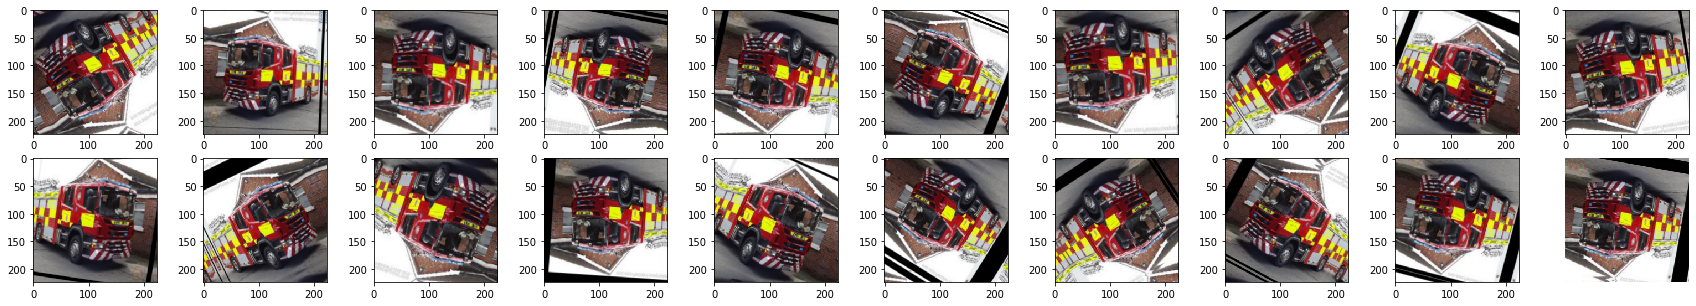

In [7]:
display_augmented(train_dataset, data_aug, preprocess=None, dtype=None)

In [8]:
base_model = ResNet50(include_top=False, input_shape=loader.image_size, classes=2)
# base_model = DenseNet121(include_top=False, input_shape=loader.image_size, classes=2)

In [9]:
# for layer in base_model.layers:
#     if layer.name.endswith("_bn"):
#         layer.trainable = False
#     else:
#         layer.trainable = False

base_model.trainable = False

In [10]:
clf_layers = Sequential([
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
])

In [11]:
inputs = tf.keras.Input(shape=loader.image_size)
x = data_aug(inputs)
x = preprocess(x)
x = base_model(x)
outputs = clf_layers(x)

model = Model(inputs, outputs)

In [12]:
# inputs, outputs = feed_forward(base_model, loader.image_size, data_aug, preprocess, clf_layers)
# model = Model(inputs, outputs)

In [17]:
base_lr = 0.001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_lr),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=["accuracy"])

In [18]:
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 524801    
Total params: 24,112,513
Trainable params: 524,801
Non-trainable params: 23,587,712
___________________________________________

In [19]:
cp_path = dirname("./models/cp.ckpt")
cp_callback = ModelCheckpoint(filepath=cp_path, save_weights_only=True, 
                              save_best_only=True, monitor="val_accuracy")

es_callback = EarlyStopping(monitor="val_accuracy", patience=7, verbose=1, baseline=0.90)
lr_callback = LearningRateScheduler(schedule=scheduler, verbose=5)

callbacks = [cp_callback, es_callback, lr_callback]

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [20]:
epochs = 50

model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, 
                    use_multiprocessing=True, workers=6, callbacks=[callbacks, tensorboard_callback])

Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
20/20 [==============================] - 122s 6s/step - loss: 0.5661 - accuracy: 0.7747 - val_loss: 0.3129 - val_accuracy: 0.8551
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
20/20 [==============================] - ETA: 0s - loss: 0.3121 - accuracy: 0.8687 

In [ ]:
model.evaluate(test_dataset)

In [131]:
model.load_weights(cp_path)

In [132]:
model.evaluate(test_dataset)

6/6 [==============================] - 17s 3s/step - loss: 0.1334 - accuracy: 0.9422


[0.13336415588855743, 0.9422492384910583]

In [24]:
fine_tune_at = 160
base_model.trainable = True

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [25]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.RMSprop(lr=base_lr / 10),
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 2099201   
Total params: 25,686,913
Trainable params: 7,619,585
Non-trainable params: 18,067,328
_________________________________________________________________


In [111]:
model.evaluate(test_dataset)

6/6 [==============================] - 19s 3s/step - loss: 0.1280 - accuracy: 0.9514


[0.12799867987632751, 0.9513677954673767]

In [125]:
y_pred = []

for n in range(4):
    y_pred.append((model.predict(test_dataset) > 0.7).astype(int))

In [133]:
y_pred = (model.predict(test_dataset) > 0.8).astype(int).flatten()

In [113]:
preds = np.array(y_pred)

In [114]:
y_test = np.array([])
for (_, label) in test_dataset.as_numpy_iterator():
    y_test = np.hstack([y_test, label])

In [116]:
print(classification_report(y_test, (preds.squeeze(axis=2).sum(axis=0) >= 4).astype(int)))

              precision    recall  f1-score   support

         0.0       0.64      0.96      0.77       209
         1.0       0.38      0.04      0.08       120

    accuracy                           0.63       329
   macro avg       0.51      0.50      0.42       329
weighted avg       0.54      0.63      0.51       329



In [46]:
fine_tune_epochs = 10
total_epochs = fine_tune_epochs + epochs

fine_tuneh = model.fit(train_dataset, epochs=total_epochs, initial_epoch=history.epoch[-1], validation_data=val_dataset, 
                    use_multiprocessing=True, workers=6, callbacks=callbacks)

Epoch 70/130
31/31 [==============================] - 103s 3s/step - loss: 0.3157 - accuracy: 0.8612 - val_loss: 0.1674 - val_accuracy: 0.9242

Epoch 00070: val_accuracy did not improve from 0.94242
Epoch 71/130
31/31 [==============================] - 99s 3s/step - loss: 0.2534 - accuracy: 0.8977 - val_loss: 0.1240 - val_accuracy: 0.9394

Epoch 00071: val_accuracy did not improve from 0.94242
Epoch 72/130
31/31 [==============================] - 98s 3s/step - loss: 0.2413 - accuracy: 0.8896 - val_loss: 0.1207 - val_accuracy: 0.9455

Epoch 00072: val_accuracy improved from 0.94242 to 0.94545, saving model to ./models
Epoch 73/130
31/31 [==============================] - 108s 4s/step - loss: 0.2163 - accuracy: 0.9098 - val_loss: 0.1190 - val_accuracy: 0.9394

Epoch 00073: val_accuracy did not improve from 0.94545
Epoch 74/130
31/31 [==============================] - 141s 5s/step - loss: 0.2294 - accuracy: 0.8997 - val_loss: 0.1637 - val_accuracy: 0.9091

Epoch 00074: val_accuracy did no

In [51]:
history.model.evaluate(val_dataset)

11/11 [==============================] - 22s 2s/step - loss: 0.1087 - accuracy: 0.9606


[0.10866749286651611, 0.960606038570404]

In [128]:
def predict_test(base_model, image_shape, preprocess, clf_layers):
    inputs = tf.keras.Input(shape=image_shape)
    x = preprocess(inputs)
    x = base_model(x, training=False)
    outputs = clf_layers(x, training=False)
    return inputs, outputs

In [129]:
base_lr = 0.001

In [130]:
inputs, outputs = predict_test(base_model, loader.image_size, preprocess, clf_layers)
model_test = Model(inputs, outputs)

model_test.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.RMSprop(lr=base_lr / 10),
              metrics=['accuracy'])

In [13]:
model_test.evaluate(test_dataset)

11/11 [==============================] - 22s 2s/step - loss: 0.7728 - accuracy: 0.5752


[0.7795528769493103, 0.5623100399971008]

In [25]:
unkown_dataset = tf.data.Dataset.from_tensor_slices((loader.images["x_test"])).batch(64)

In [70]:
predictions = model_test.predict(unkown_dataset, use_multiprocessing=True, workers=6)

In [71]:
test_df = pd.read_csv(path+"/test.csv")
test_df = test_df.assign(emergency_or_not=(predictions > 0).astype(int).flatten())

test_df.to_csv("./submissions/resnet50.csv", index=False)